Aaron Gregory
CSC578 Final Time Series Notebook
Async Section

In [ ]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
#Downloading the dataset
csv_path = tf.keras.utils.get_file(
    origin='https://reed.cs.depaul.edu/peterh/Essays/Metro_Interstate_reduced.csv',
    fname='Metro_Interstate_reduced.csv',
    cache_dir='/content', cache_subdir='sample_data')

Data Analysis
AG - The next few sections are just preparing the data and seeing what we have to work with before I build my model. The first thing I did was drop weather description and weather main since they are strings.

In [ ]:
df = pd.read_csv(csv_path)
#date_time = pd.to_datetime(df.pop('date_time'), format='%Y.%m.%d %H:%M:%S')
df = df.drop('weather_description', 1)
df = df.drop('weather_main', 1)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


,holiday,temp,rain_1h,snow_1h,clouds_all,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,2012-10-02 13:00:00,4918


AG- I then converted the holiday feature to a bianary of either a holiday or not a holiday. Holidays are so infrequent I didn't want to do anything more aggressive

In [ ]:
#Replacing holiday with a binary, 1 for having a holiday and 0 for not a holiday
for i in range(len(df['holiday'])):
  if len(df['holiday'][i]) >6:
    df['holiday'][i]=1
  else:
    df['holiday'][i]=0
df.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,holiday,temp,rain_1h,snow_1h,clouds_all,date_time,traffic_volume
0,0,288.28,0.0,0.0,40,2012-10-02 09:00:00,5545
1,0,289.36,0.0,0.0,75,2012-10-02 10:00:00,4516
2,0,289.58,0.0,0.0,90,2012-10-02 11:00:00,4767
3,0,290.13,0.0,0.0,90,2012-10-02 12:00:00,5026
4,0,291.14,0.0,0.0,75,2012-10-02 13:00:00,4918


In [ ]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,40575.000000,40575.000000,40575.000000,40575.000000,40575.000000
mean,281.316763,0.318632,0.000117,44.199162,3290.650474
std,13.816618,48.812640,0.005676,38.683447,1984.772909
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,271.840000,0.000000,0.000000,1.000000,1248.500000
50%,282.860000,0.000000,0.000000,40.000000,3427.000000
75%,292.280000,0.000000,0.000000,90.000000,4952.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


AG- I removed the erronius rain data point and erronius temp data point. There is one point that says it rained 10 meters in an hour which doesn't sound possible. Also a temperature of 0 kelvins is not possible so this too was removed

In [ ]:
for i  in range(len(df.rain_1h)):
  if df.rain_1h[i]> 1000:
    df.rain_1h[i]=0
print(max(df.rain_1h))
for i  in range(len(df.temp)):
  if df.temp[i]< 100:
    df.temp[i]=281
print(min(df.temp))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


55.63


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


243.39


AG- Below we are minipulating the time and data the same was as in the example. This is because time is cyclical and we need the end of the day (midnight) to be close to the begining of the new day (1am). This code was taken from the example

In [ ]:
date_time = pd.to_datetime(df.pop('date_time'), format='%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

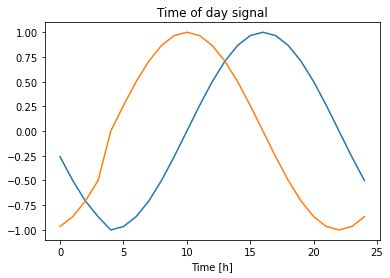

In [ ]:
plt.plot(np.array(df['Day sin'])[25:50])
plt.plot(np.array(df['Day cos'])[25:50])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

AG - Below are histograms of the reamining data after I cleaned it up. You'll notice that rain and snow are heavily skewed since it is not precipitating most of the time. I'm not sure why there are spikes at -1 and 1 for the year and day/ cos/sin data but that is something that could be looked into. I would've expected traffic to have a normal or binormal distribution.

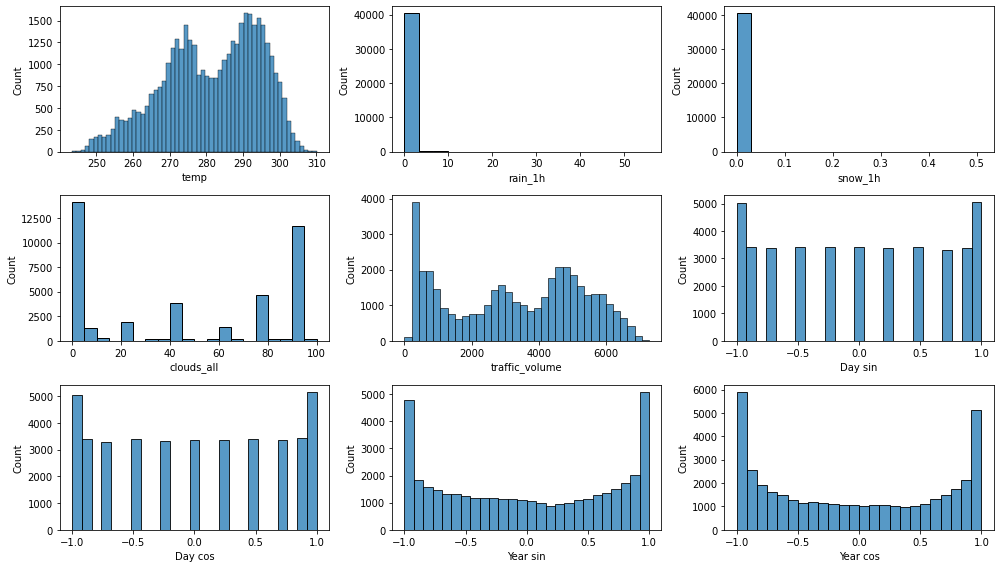

In [ ]:
df_cols = df.select_dtypes(exclude='object').columns
fig = plt.figure( figsize=(14,8))
for i, col in enumerate(df_cols):
    ax=fig.add_subplot(rows,cols,i+1)   
    sns.histplot(x = df[col], ax = ax)
fig.tight_layout()  
plt.show()

AG-Splitting and normalizing the data into testing and training data, taken from the example. I added the indexs so we had 5000 in the test set though.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):35575]
test_df = df[35575:]

num_features = df.shape[1]
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
#Verificatinon of sample set sizes and standardization
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
test_df.head()

(28402, 10)
(7173, 10)
(5000, 10)


,holiday,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day sin,Day cos,Year sin,Year cos
35575,-0.036602,-0.686063,-0.104652,-0.024705,1.148524,-1.339931,-0.364483,1.351576,1.214907,0.590054
35576,-0.036602,-0.680655,-0.104652,-0.024705,1.148524,-1.486210,0.002393,1.399654,1.215364,0.589152
35577,-0.036602,-0.680655,-0.104652,-0.024705,1.148524,-1.519386,0.369269,1.351576,1.215821,0.588251
35578,-0.036602,-0.686063,-0.104652,-0.024705,1.148524,-1.524915,0.711143,1.210617,1.216278,0.587349
35579,-0.036602,-0.692243,-0.104652,-0.024705,1.148524,-1.472637,1.004717,0.986384,1.216733,0.586447


AG - This Function creates a window so that we can use a moving window for inputs and target data. This is from the example

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns="traffic_volume"):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

AG - Ploting the Results, from the example

In [ ]:
def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

AG - Split window function from the example. This is so the data can be fed into the model with the appropriate slices for each timepoint

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

AG - Making the Dataset. Taken from example.Turned shuffle off. It took me a long time to figure out that was causing me issues. This turns our data into a 3d object that keras can recognize and work with.

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=30,)
  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset
WindowGenerator.make_dataset = make_dataset
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result
  
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Finally the RNN Modeling Begins

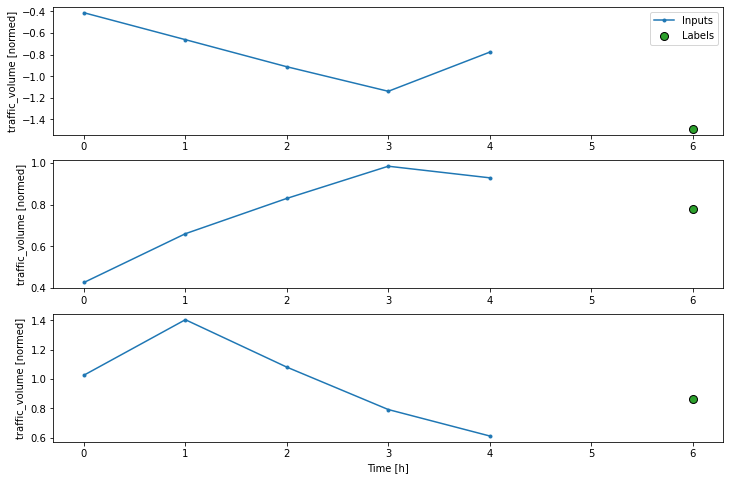

In [ ]:
#Showing that my window size is working correctly
RNNwindow.plot()

AG - I stole this error plot from my last homework to track the models learning via mean absolute error.

In [ ]:
#Error Plot to plot model learning
def errorPlt():
  plt.plot(history.history['mean_absolute_error'], label='training accuracy')
  plt.plot(history.history['val_mean_absolute_error'], label = 'valid. accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.ylim([0.0, 1])
  plt.legend(loc='upper right')


In [ ]:
MAX_EPOCHS = 100
def compile_and_fit(model, window, patience=4):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=['MeanAbsoluteError'])
  
  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history
val_performance = {}

AG - This was my baseline model. It is just a CNN like we have used previously but I wanted to use it as my baseline since I understood how it works better. I did not try to optimize this as the goal was a RNN not a CNN. This model had a mean absolute error of 0.155 and a loss of 0.049.

167/167 [==============================] - 1s 4ms/step - loss: 0.0492 - mean_absolute_error: 0.1549


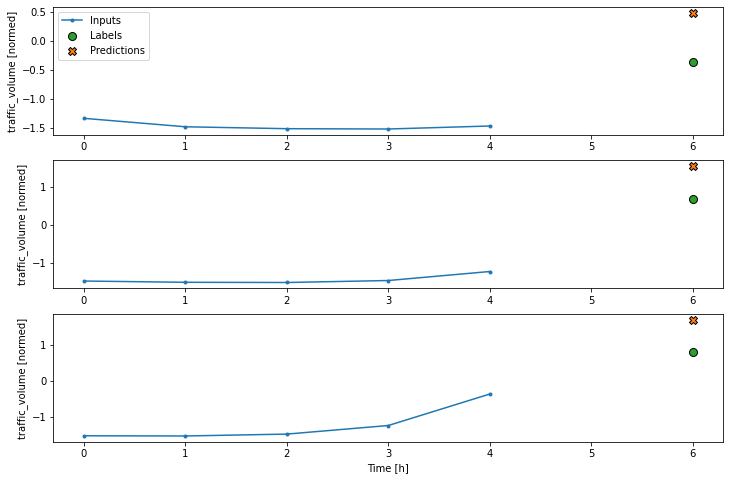

In [ ]:
#Baseline CNN model
CONV_WIDTH = 5
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=2,
    label_columns=['traffic_volume'])
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
history = compile_and_fit(multi_step_dense, conv_window)
IPython.display.clear_output()
multi_step_dense.evaluate(RNNwindow.test)
conv_window.plot(multi_step_dense)


AG - After I showed that I could get a working model with the correct output report I made this baseline RNN model. It is taken from the example with no frills or optimizations. The MAE was 0.135 and the loss was 0.039

In [ ]:
#RNN Base Model
RNNwindow = WindowGenerator(
    input_width=5, label_width=1, shift=2, label_columns=['traffic_volume'])

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(200, return_sequences=False),
    tf.keras.layers.Dense(units=num_features)
])
history = compile_and_fit(lstm_model, RNNwindow)
IPython.display.clear_output()
lstm_model.evaluate(RNNwindow.test)


167/167 [==============================] - 1s 4ms/step - loss: 0.0388 - mean_absolute_error: 0.1345


[0.03881625831127167, 0.13446037471294403]

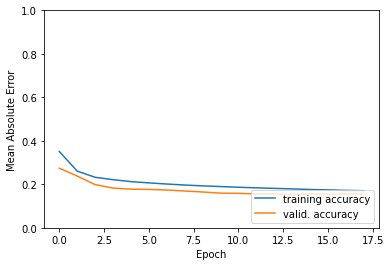

In [ ]:
errorPlt()

AG - The first real improvement I made was adding more LSTM layers and adding dropout. I found that adding dropout helped a lot with the last homework. I originally had less units but it was training too slow. MAE=0.131 Loss= 0.036

167/167 [==============================] - 1s 5ms/step - loss: 0.0358 - mean_absolute_error: 0.1307


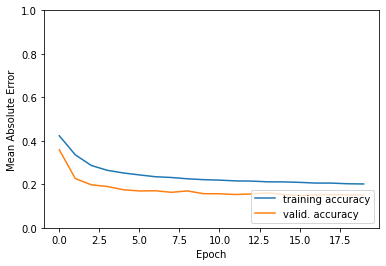

In [ ]:
#RNN Upgrade 1 
RNNwindow = WindowGenerator(
    input_width=5, label_width=1, shift=2, label_columns=['traffic_volume'])

lstm_model1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(150, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(150, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(150, return_sequences=False),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(units=num_features)
])
history = compile_and_fit(lstm_model1, RNNwindow)
IPython.display.clear_output()
lstm_model1.evaluate(RNNwindow.test)
errorPlt()

In [ ]:
valid_loss, valid_acc = lstm_model1.evaluate(RNNwindow.test, verbose=2) 
print ("valid_accuracy=%s, valid_loss=%s" % (valid_acc, valid_loss))

167/167 - 1s - loss: 0.0322 - mean_absolute_error: 0.1198 - 787ms/epoch - 5ms/step
valid_accuracy=0.11977901309728622, valid_loss=0.032199058681726456


AG - I tried a bunch to introduce some GRU functionality but it made the model worse. I also had some issues getting the inputs for the GRU to be the correct shape/size. I would've expected to the addition to do better since it does a better job of controlling what information gets passed on. MAE= 0.179 Loss= 0.070

167/167 [==============================] - 1s 5ms/step - loss: 0.0696 - mean_absolute_error: 0.1787


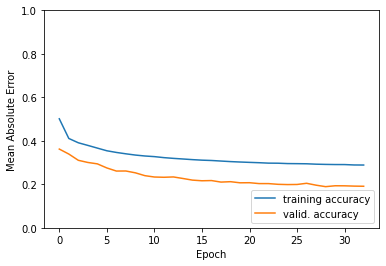

In [ ]:
#RNN Model 2 
RNNwindow = WindowGenerator(
    input_width=5, label_width=1, shift=2, label_columns=['traffic_volume'])

lstm_model2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(75, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(75, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GRU(75,activation='tanh', return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=num_features)
])
history = compile_and_fit(lstm_model2, RNNwindow)
IPython.display.clear_output()
lstm_model2.evaluate(RNNwindow.test)
errorPlt()

AG - My final model is similar to my first upgraded model with multiple LSTM layers with dropout. For this final model I experimented with units size extensivly. I found that learning was much slower but stady when the unit size was low. I also found that when the unit size was high my model would end early since it was so slow at learning. I ended up choosing 150 since it was faster but having a slightly lower number could be beneficial if epochs were increased.
MAE = 0.118 Loss = 0.030

167/167 [==============================] - 1s 6ms/step - loss: 0.0300 - mean_absolute_error: 0.1179


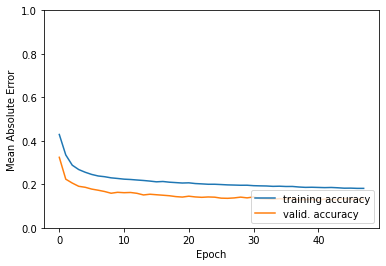

In [ ]:
#Final Model
RNNwindow = WindowGenerator(
    input_width=5, label_width=1, shift=2, label_columns=['traffic_volume'])

lstm_model2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(150, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(150, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(150, return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=num_features)
])
history = compile_and_fit(lstm_model2, RNNwindow)
IPython.display.clear_output()
lstm_model2.evaluate(RNNwindow.test)
errorPlt()

Creating an outputfile for the predicted values of the RNN

In [ ]:
#AG This is just a check to make sure that I am getting reasonable results out of my predict function
fpreds=lstm_model2.predict(k)
preds=fpreds[:,5]
preds[:5]

array([-0.19052474,  1.23282   ,  1.6089833 ,  0.8411413 ,  0.8081713 ],
      dtype=float32)

AG Below are is how I wrote the results to a file. Note that the variable k is just the transformed input data for the test data. For the final model the output was 4994x10x1 so I needed to index into the 5th column which was the vehicle total. I also decided to just denormalize the data while writing the output file. I had to pull the training standard deviation and mean for traffic volume for this

In [ ]:
#Output Files Generator for Baseline Model
predictions=multi_step_dense.predict(k)
pred=[]
for i in predictions:
  pred.append(i[0][0]*train_std["traffic_volume"]+train_mean["traffic_volume"])
f = open("Traffic Volume Baseline Predictions.csv", "a")
f.write("id,prediction")
f.write("\n")
for i in range(len(pred)):
  f.write(str(i+1)+",")
  f.writelines(str(pred[i]))
  f.write("\n")
f.write("\n")
f.close()

In [ ]:
#Predicting the vehicle totals
fpreds=lstm_model2.predict(k)
preds=fpreds[:,5]
f = open("Traffic Volume Predictions 3.csv", "a")
f.write("id,prediction")
f.write("\n")
id=0
for i in preds:
  vehicles=round(i*train_std["traffic_volume"]+train_mean["traffic_volume"],2)
  f.write(str(1+id)+",")
  f.writelines(str(vehicles))
  id+=1
  f.write("\n")
f.write("\n")
f.close()